In [1]:
import os
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

In [2]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set dataset path
dataset_path = "/content/drive/MyDrive/dsgp datasets/"


Mounted at /content/drive


In [3]:
# ✅ Check if the dataset exists
if not os.path.exists(dataset_path):
    print(f"❌ Error: Dataset path '{dataset_path}' not found. Please check your Google Drive folder.")
else:
    print(f"✅ Dataset found at: {dataset_path}")

✅ Dataset found at: /content/drive/MyDrive/dsgp datasets/


In [4]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

# ✅ Corrected folder mapping (Use exact names from Drive)
plant_deficiency_mapping = {
    "Rice folder": ["Potassium(K)", "Nitrogen(N)", "Phosphorus(P)"],
    "Banana folder": ["IronB", "MagnesiumB", "PotassiumB"],
    "Coffee folder": ["PotassiumC", "IronC", "MagnesiumC"]
}

# ✅ Define the dataset path
dataset_path = "/content/drive/MyDrive/dsgp datasets"

# ✅ Function to preprocess images
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ Warning: Could not read {image_path}, skipping...")
        return None
    img = cv2.resize(img, (224, 224))  # Resize for ResNet (224x224)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = img_to_array(img)  # Convert image to array
    img = preprocess_input(img)  # Preprocess for ResNet50
    return img

# ✅ Load images and labels
X_data = []  # Image data
y_labels = []  # Labels for the data
label_mapping = {}  # To store numerical labels for classes
label_index = 0  # Initialize label index

# ✅ Iterate over the plant deficiency mapping and process the images
for plant, deficiencies in plant_deficiency_mapping.items():
    for deficiency in deficiencies:
        deficiency_path = os.path.join(dataset_path, plant, deficiency)
        if os.path.exists(deficiency_path):
            if deficiency not in label_mapping:
                label_mapping[deficiency] = label_index
                label_index += 1

            # Process all images in the deficiency subfolder
            for img_name in os.listdir(deficiency_path):
                img_path = os.path.join(deficiency_path, img_name)
                # Preprocess image
                img = preprocess_image(img_path)

                if img is not None:
                    X_data.append(img)
                    y_labels.append(label_mapping[deficiency])
        else:
            print(f"⚠️ Warning: Directory '{deficiency_path}' not found, skipping...")

# ✅ Convert to NumPy arrays
X_data = np.array(X_data)
y_labels = np.array(y_labels)

print(f"✅ Loaded {len(X_data)} images with {len(set(y_labels))} unique classes.")


✅ Loaded 1884 images with 9 unique classes.


In [5]:
# ✅ Severity Mapping for each deficiency (You can modify this based on your dataset)
severity_mapping = {
    "Potassium(K)": "moderate",  # Example: moderate severity
    "Nitrogen(N)": "mild",  # Example: mild severity
    "Phosphorus(P)": "severe",  # Example: severe severity
    "IronB": "mild",
    "MagnesiumB": "moderate",
    "PotassiumB": "severe",
    "PotassiumC": "mild",
    "IronC": "severe",
    "MagnesiumC": "moderate"
}

# ✅ Encode severity labels as numeric values (e.g., mild=0, moderate=1, severe=2)
severity_encoded = {
    "mild": 0,
    "moderate": 1,
    "severe": 2
}

# ✅ Map severity labels to numeric values
y_severity = []
for deficiency in y_labels:
    plant_deficiency = list(label_mapping.keys())[list(label_mapping.values()).index(deficiency)]
    severity_label = severity_mapping.get(plant_deficiency, "mild")  # Default to "mild" if not found
    severity_numeric = severity_encoded.get(severity_label, 0)  # Default to 0 if not found
    y_severity.append(severity_numeric)

# ✅ Convert to NumPy array
y_severity = np.array(y_severity)

print(f"✅ Encoded severity labels: {len(set(y_severity))} unique severity levels.")


✅ Encoded severity labels: 3 unique severity levels.


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# ✅ Load the ResNet50 model (without the top layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ✅ Add a GlobalAveragePooling layer to flatten the features
x = base_model.output
x = GlobalAveragePooling2D()(x)

# ✅ Create a model for feature extraction
feature_extractor = Model(inputs=base_model.input, outputs=x)

# ✅ Define a function to extract features from an image
def extract_features(img):
    # Reshape and expand the dimensions of the image to match the input format of ResNet50
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    # Extract features using ResNet50 model
    features = feature_extractor.predict(img)
    return features.flatten()  # Flatten the features to 1D

# ✅ Extract features for all images
X_features = []
for img in X_data:
    features = extract_features(img)
    X_features.append(features)

# ✅ Convert features to a NumPy array
X_features = np.array(X_features)

print(f"✅ Extracted features for {len(X_features)} images.")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━

In [7]:
from sklearn.model_selection import train_test_split

# ✅ Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_severity, test_size=0.2, random_state=42)

print(f"✅ Train data: {X_train.shape[0]} samples")
print(f"✅ Test data: {X_test.shape[0]} samples")


✅ Train data: 1507 samples
✅ Test data: 377 samples


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Create the neural network model
model = Sequential()

# Input layer with stronger L2 regularization and fewer units
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.05)))  # Reduced from 512, stronger L2
model.add(Dropout(0.7))  # Increased from 0.6 to 0.7

# Output layer
model.add(Dense(3, activation='softmax'))

# Compile the model (keeping learning rate at 0.0001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

# EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)  # Changed to val_accuracy
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4006 - loss: 23.4737 - val_accuracy: 0.7162 - val_loss: 21.0724 - learning_rate: 1.0000e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5114 - loss: 20.9279 - val_accuracy: 0.7401 - val_loss: 19.2295 - learning_rate: 1.0000e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6424 - loss: 18.9386 - val_accuracy: 0.7719 - val_loss: 17.4488 - learning_rate: 1.0000e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6568 - loss: 17.1609 - val_accuracy: 0.8117 - val_loss: 15.7674 - learning_rate: 1.0000e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6998 - loss: 15.4928 - val_accuracy: 0.8170 - val_loss: 14.2029 - learning_rate: 1.0000e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7354 - loss: 13.9664 - val_accuracy: 0.8196 - val_loss: 12.7705 - learning_rate: 1.0000e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8019

In [9]:
# Retrieve training accuracy from history
train_accuracy = history.history['accuracy']

# Print the last training accuracy (after the final epoch)
print(f"✅ Final Training Accuracy: {train_accuracy[-1]:.4f}")


✅ Final Training Accuracy: 0.8673


In [10]:
# Save the model as .h5
model.save('latest_model_for_severity.h5', save_format='h5')
print("Model saved as 'latest_model_for_severity.h5'")

# Check if the file exists in the current directory
import os
print("Current directory:", os.getcwd())
print("Files in directory:", os.listdir())

Model saved as 'latest_model_for_severity.h5'
Current directory: /content
Files in directory: ['.config', 'drive', 'latest_model_for_severity.h5', 'sample_data']


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


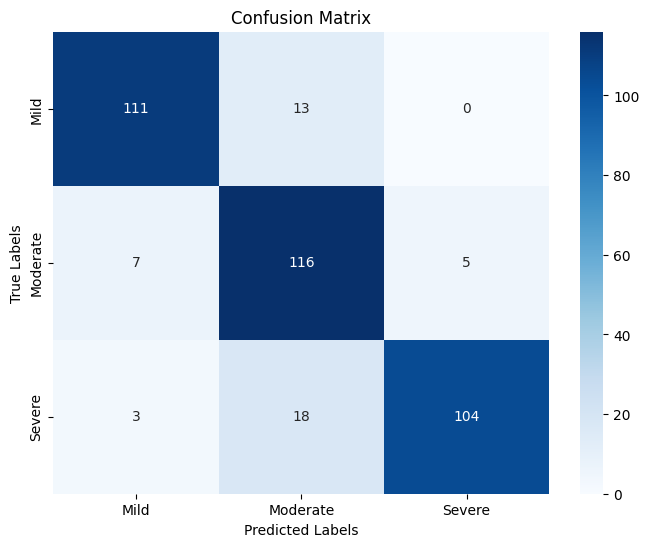

Confusion Matrix:
[[111  13   0]
 [  7 116   5]
 [  3  18 104]]


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with highest probability

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Mild', 'Moderate', 'Severe'], yticklabels=['Mild', 'Moderate', 'Severe'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the confusion matrix for further inspection
print("Confusion Matrix:")
print(cm)


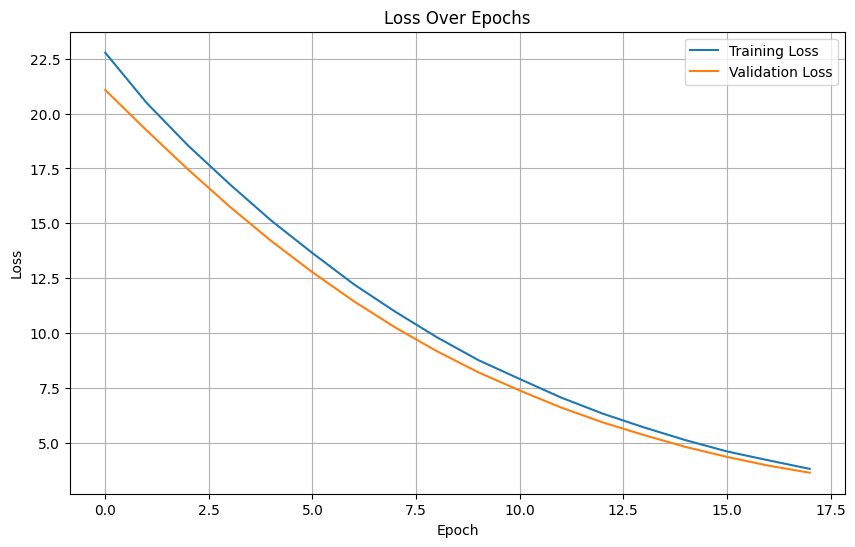

In [12]:
# 1. Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

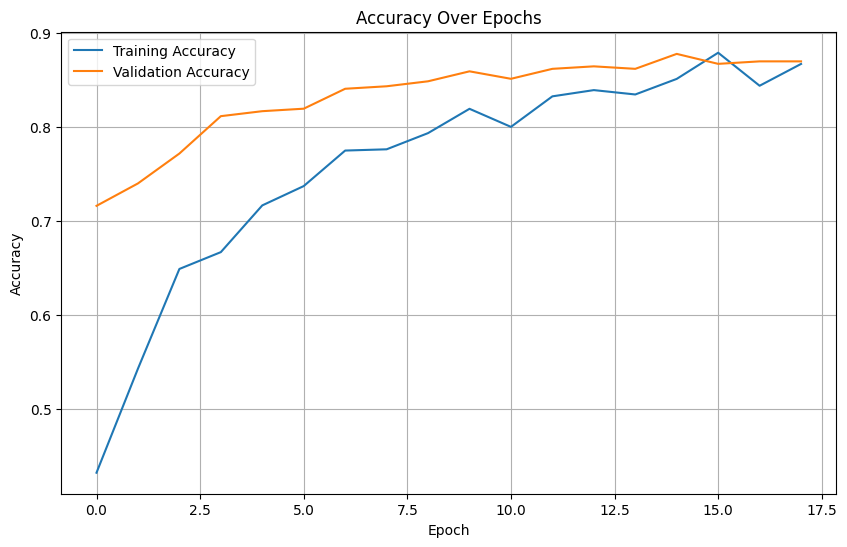

In [13]:
# 2. Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import numpy as np

# Get model predictions (probabilities)
y_pred = model.predict(X_test)

# Convert probabilities to class labels (0, 1, 2 for mild, moderate, severe)
y_pred_classes = np.argmax(y_pred, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [15]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred_classes, target_names=['Mild', 'Moderate', 'Severe'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        Mild       0.92      0.90      0.91       124
    Moderate       0.79      0.91      0.84       128
      Severe       0.95      0.83      0.89       125

    accuracy                           0.88       377
   macro avg       0.89      0.88      0.88       377
weighted avg       0.89      0.88      0.88       377



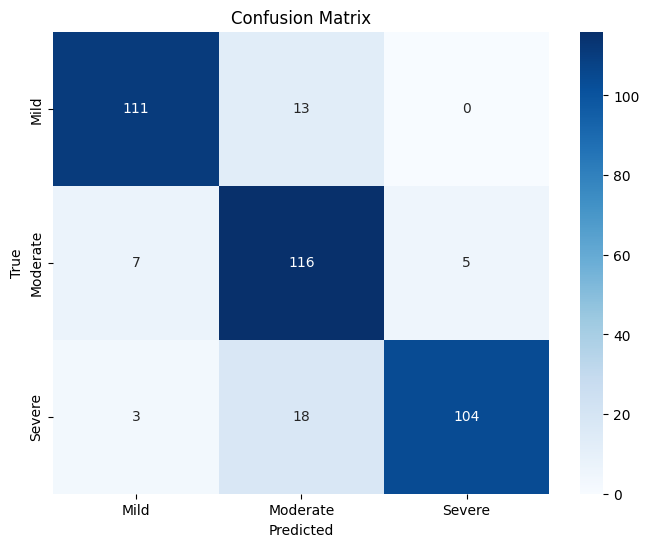

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Mild', 'Moderate', 'Severe'],
            yticklabels=['Mild', 'Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate individual metrics
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")

Precision (weighted): 0.8860
Recall (weighted): 0.8780
F1-Score (weighted): 0.8792


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


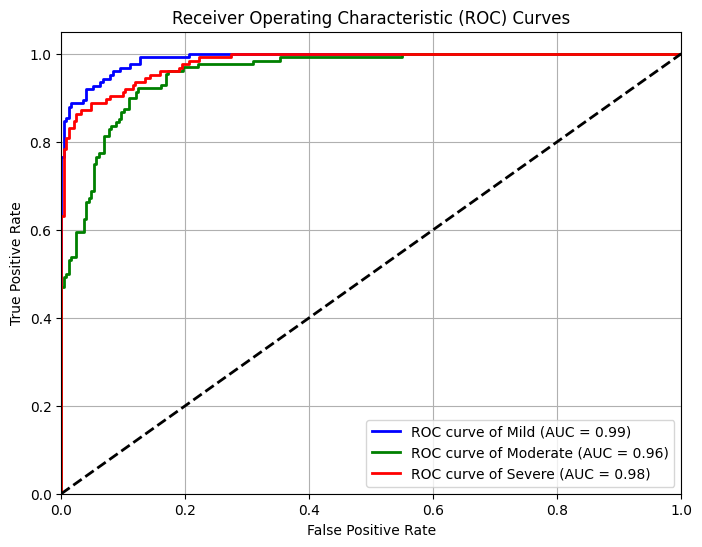

AUC Scores for each class:
Mild: 0.9898
Moderate: 0.9567
Severe: 0.9803


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the test labels for ROC (One-vs-Rest)
n_classes = 3  # Number of classes: Mild (0), Moderate (1), Severe (2)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Get the predicted probabilities for each class
y_pred_prob = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()  # False Positive Rate
tpr = dict()  # True Positive Rate
roc_auc = dict()  # AUC score

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'green', 'red'])
class_names = ['Mild', 'Moderate', 'Severe']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line (random guessing)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print AUC scores for each class
print("AUC Scores for each class:")
for i in range(n_classes):
    print(f"{class_names[i]}: {roc_auc[i]:.4f}")

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the test labels for AUC (One-vs-Rest)
n_classes = 3  # Number of classes: Mild (0), Moderate (1), Severe (2)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Get the predicted probabilities for each class
y_pred_prob = model.predict(X_test)

# Compute AUC for each class (One-vs-Rest)
auc_scores = []
class_names = ['Mild', 'Moderate', 'Severe']

for i in range(n_classes):
    auc_score = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
    auc_scores.append(auc_score)
    print(f"AUC for {class_names[i]}: {auc_score:.4f}")

# Compute the average AUC (macro average)
macro_auc = sum(auc_scores) / n_classes
print(f"Macro-average AUC: {macro_auc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
AUC for Mild: 0.9898
AUC for Moderate: 0.9567
AUC for Severe: 0.9803
Macro-average AUC: 0.9756


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


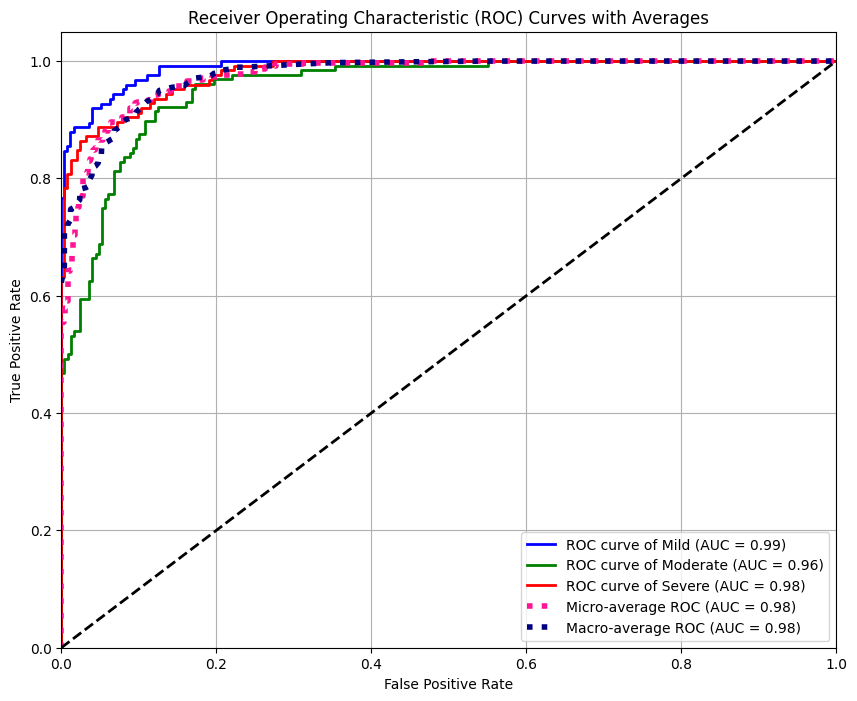

Mild: 0.9898
Moderate: 0.9567
Severe: 0.9803
Micro-average: 0.9755
Macro-average: 0.9765


In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np

# Binarize the test labels for ROC (One-vs-Rest)
n_classes = 3  # Number of classes: Mild (0), Moderate (1), Severe (2)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Get the predicted probabilities for each class
y_pred_prob = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()  # False Positive Rate
tpr = dict()  # True Positive Rate
roc_auc = dict()  # AUC score

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and AUC
# First, interpolate all ROC curves at the same points
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'green', 'red'])
class_names = ['Mild', 'Moderate', 'Severe']

# Plot ROC for each class
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', lw=4,
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})')

# Plot macro-average ROC
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle=':', lw=4,
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})')

# Plot the diagonal line (random guessing)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves with Averages')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print AUC scores for each class and averages

for i in range(n_classes):
    print(f"{class_names[i]}: {roc_auc[i]:.4f}")
print(f"Micro-average: {roc_auc['micro']:.4f}")
print(f"Macro-average: {roc_auc['macro']:.4f}")